In [1]:
#Usual Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Wrangling
We perform the data wrangling steps previously detailed in the Data Story step.

In [2]:
billboard_data = pd.read_csv("all_charts.csv",low_memory=False)
spotify_data = pd.read_csv("audio_features.csv")
billboard_lyrics = pd.read_csv("all_lyrics.csv",encoding='latin1')
billboard_sub = billboard_data[["chartDate","title","artist","peakPos","lastPos","weeks","rank","change","spotifyID"]]
spotify_sub = spotify_data[["acousticness", "danceability", "duration_ms", "energy", "id","instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature","valence"]]
merged_data=pd.merge(billboard_sub,spotify_sub, how="outer",left_on="spotifyID",right_on="id")
#Replace weird characters:
merged_data=merged_data.replace({'\x83': '?'}, regex=True).replace({'\x82': '?'}, regex=True).replace({'\x80\x9c': '??'}, regex=True)
lyrics_sub=billboard_lyrics[["artist","lyrics","track","source"]]
big_dataset=pd.merge(merged_data, lyrics_sub,  how="outer",left_on=["artist","title"],right_on=["artist", "track"])
year = big_dataset.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
year_data=pd.concat([big_dataset,year],axis=1)

# Song Popularity Prediction
For the purposes of this project we say that a song is popular if it reaches the top ten, this is given by songs with 'peakPos'<=10. We separate the songs into two categories and then keep only the songs for which we have Spotify audio metadata. Here, we use a binary classifier in the 'top_ten_hit' column.

In [3]:
year_data_ten=year_data[year_data.lastPos==0]
top_ten_prediction=year_data_ten[['peakPos', 'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']]
top_ten_prediction['top_ten_hit']= np.where(top_ten_prediction.peakPos<=10, 1,0)
top_ten_no_na=top_ten_prediction.drop('peakPos', 1).dropna()

C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [4]:
len(top_ten_no_na)

23130

We have 23130 songs to work with although some may be repetitions.

## Which songs are we missing?

In [5]:
missing_rows=year_data_ten[year_data_ten['mode'].isnull()]
missing_rows.describe()

,peakPos,lastPos,weeks,rank,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,source,year
count,5483,5483,5483,5483,,,,,,,,,,,,,,3174,5483
mean,58,0,8,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1980
std,29,0,6,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,14
min,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1958
25%,34,0,3,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1968
50%,62,0,7,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1977
75%,84,0,11,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1989
max,100,0,65,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2017


** We're missing audio features for 5483 songs. Since the average of the rank is 85 most of the data we are missing is for songs very far down on the charts. ** 

We might need to take this into account when interpreting the accuracy of our models.

# Data Visualization

The key variable is an integer between zero and eleven and time signature is an integer between 2 and 5. These are not on a numerical scale so we introduce dummy indicator variables to distinguish between the cases when using linear regression.

In [6]:
# create dummy variables using get_dummies, then exclude the first dummy column
key_dummies = pd.get_dummies(top_ten_no_na.key, prefix='key').iloc[:, 1:]
time_dummies = pd.get_dummies(top_ten_no_na.time_signature, prefix='time').iloc[:, 1:]
# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
top_ten_no_na_dum = pd.concat([top_ten_no_na, key_dummies,time_dummies], axis=1)

We check the histograms to see how they are distributed.

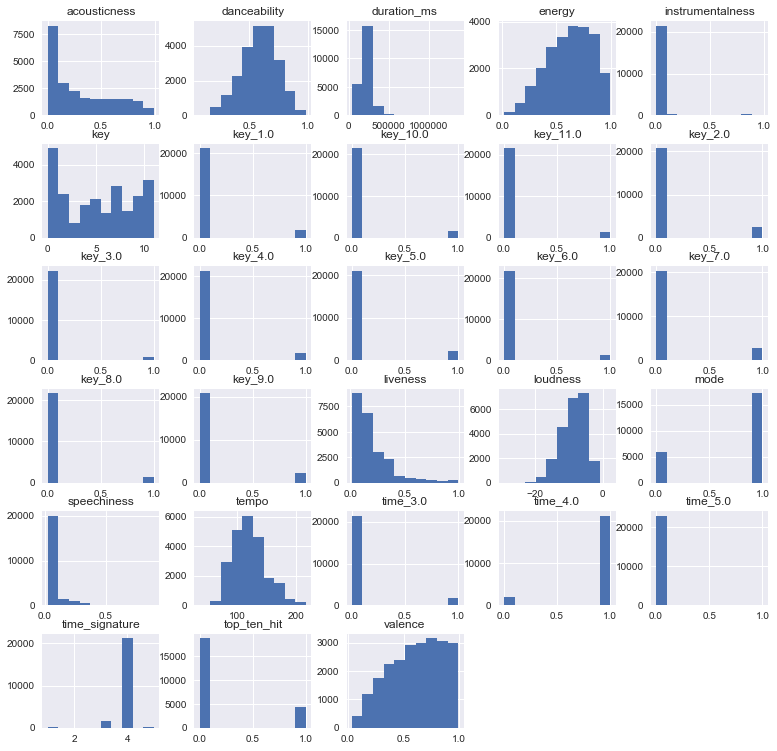

In [7]:
# Univariate Histograms
top_ten_no_na_dum.hist(figsize=(13, 13))
plt.show()

We've already discussed these distributions in the data story. We also perform a box and whiskers plot.

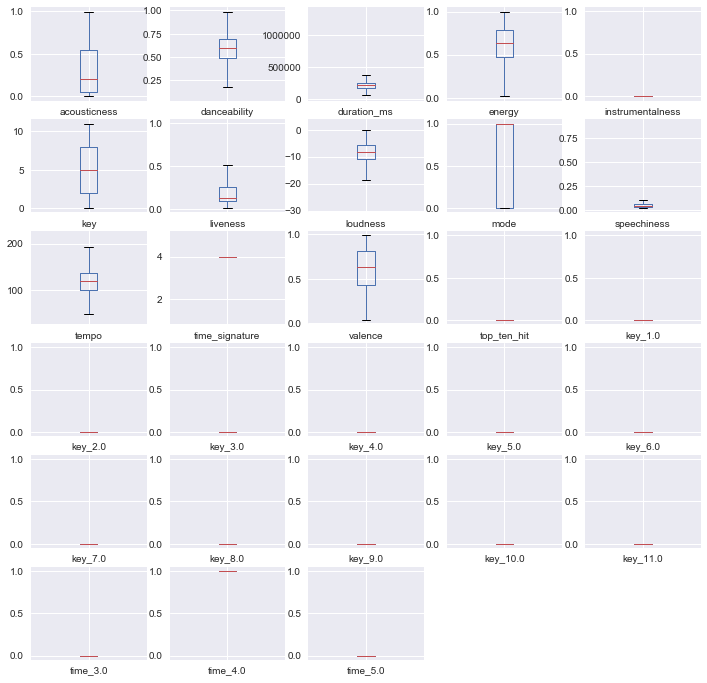

In [8]:
top_ten_no_na_dum.plot(kind='box', subplots=True,layout=(6,5), figsize=(12, 12), sharex=False, sharey=False)
plt.show()

From this we see there are a few outliers for the duration variable. We also look at the correlation matrices for the variables.

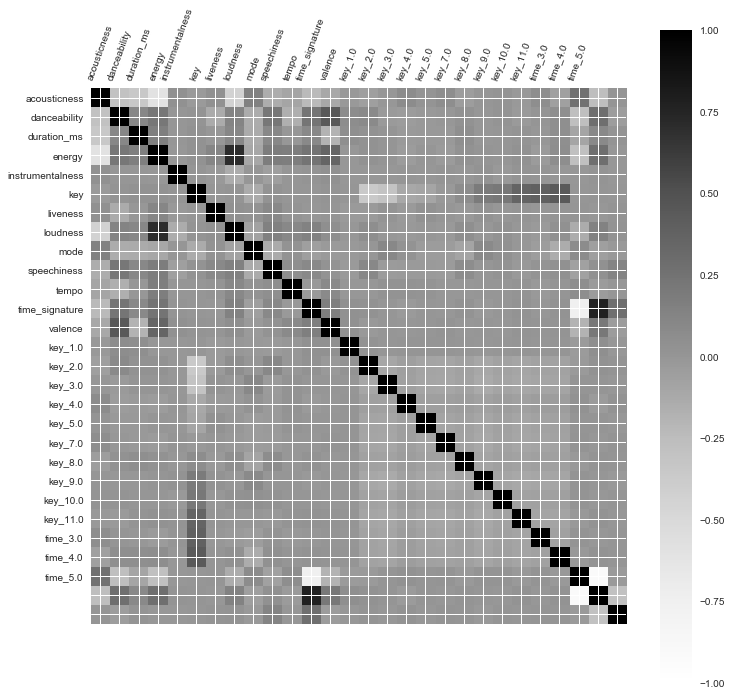

In [9]:
correlations = top_ten_no_na_dum.corr()
# plot correlation matrix
fig = plt.figure(figsize=(12, 12))
names=linear_feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','key_1.0','key_2.0','key_3.0','key_4.0','key_5.0','key_7.0','key_8.0','key_9.0','key_10.0','key_11.0','time_3.0','time_4.0','time_5.0']
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,28,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names,rotation=70)
ax.set_yticklabels(names)
plt.show()

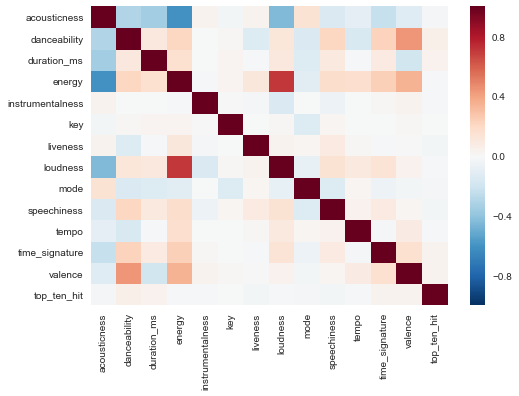

In [10]:
corr = top_ten_no_na.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

From this we see a high positive correlation between energy and loudness and high negative correlation between acousticness and both loudness and energy. 

# Machine Learning Modelling Phase

In [12]:
# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

# Classificaiton Algorithms
We first create an algorithm using GridSearch to optimize the parameters in the cross-validation stage. We will initially use 5-fold cross-validation. 

In [13]:
# Given a set of hyperparameters and training data we use Grid Search to find the best choice of hyperparameters
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

We write the following classification algorithm that we can use with multiple machine learning models given a dataset, target variable and hyperparameters.

In [14]:
# we use a 80-20 Train-Test split by default and do not standardize the audiodata metadata features
# We set the seed to 7 to obtain consistent results
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8,seed = 7):
    #To create the 'X' dataset we first standardize by the mean and standard deviation is standardize is set to True
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    #Create the 'X' and 'y' datasets
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    #Split X and y into training and test data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size,random_state=seed)
    #Now implement GridSearchCV for the cross validation steop 
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    #Use the classifier to fit the training data
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.5f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

# Linear Regression
For linear regression we need to use the dummy variables.

In [15]:
from sklearn.linear_model import LinearRegression
# We initially do not set any parameters for the Linear Regression model
params = {}
linear_feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','key_1.0','key_2.0','key_3.0','key_4.0','key_5.0','key_7.0','key_8.0','key_9.0','key_10.0','key_11.0','time_3.0','time_4.0','time_5.0']
clf_linear, Xtrain_linear, ytrain_linear, Xtest_linear, ytest_linear  = do_classify(LinearRegression(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)

BEST PARAMS {}
Accuracy on training data: 0.01106
Accuracy on test data:     0.00497


In [16]:
# pair the feature names with the coefficients
pd.options.display.float_format = '{:20,.7f}'.format
pd.DataFrame(list(zip(linear_feature_cols, clf_linear.coef_)), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,acousticness,0.0047096
1,danceability,0.1468969
2,duration_ms,0.0000003
3,energy,-0.0872345
4,instrumentalness,-0.0147854
5,key,-0.0010887
6,liveness,-0.0201991
7,loudness,0.0007619
8,mode,-0.0136968
9,speechiness,-0.2372014


From this we see that a higher danceability score is a positive indicator of obtaining a top ten hit whereas, songs with higher speechiness values are negatively associated with top ten hits. The other variable of influence is energy where top ten songs are negatively associated with energy.

In [17]:
test_prediction=clf_linear.predict(Xtest_linear)
msetest = np.mean((ytest_linear - test_prediction) ** 2)
print ("The mean squared error of the test data is ", msetest)
train_predict=clf_linear.predict(Xtrain_linear)
msetrain = np.mean((ytrain_linear - train_predict) ** 2)
print ("The mean squared error of the training data is ", msetrain)

The mean squared error of the test data is  0.149644657818
The mean squared error of the training data is  0.150675790417


** The level of accuracy is less than 50% which is around what we should expect with guessing. Something is wrong here! **

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
params = {"C": [0.001, 0.1, 1, 10, 100]}
clf_log, Xtrain_log, ytrain_log, Xtest_log, ytest_log  = do_classify(LogisticRegression(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)

BEST PARAMS {'C': 0.001}
Accuracy on training data: 0.81247
Accuracy on test data:     0.81561


In [19]:
# pair the feature names with the coefficients
clf_log.coef_

array([[ -7.79539830e-05,  -3.29560683e-05,  -1.24021712e-06,
         -5.65572497e-05,  -6.22239772e-06,  -5.63477859e-04,
         -3.46580097e-05,   9.80096720e-04,  -1.18689413e-04,
         -1.09549359e-05,  -9.56180820e-03,  -3.76253015e-04,
         -5.37523109e-05,   1.33119911e-05,  -1.45295226e-05,
         -6.35389305e-06,  -5.78348350e-06,  -1.38835998e-05,
         -2.07107092e-05,  -9.88086586e-06,  -5.81293030e-06,
         -1.11426149e-05,  -3.09719339e-08,  -4.16048258e-05,
         -5.66828000e-05,  -4.20586922e-06]])

In [20]:
test_prediction_log=clf_log.predict(Xtest_log)
print(confusion_matrix(ytest_log,test_prediction_log))
print(classification_report(ytest_log,test_prediction_log))

[[3773    0]
 [ 853    0]]
             precision    recall  f1-score   support

          0       0.82      1.00      0.90      3773
          1       0.00      0.00      0.00       853

avg / total       0.67      0.82      0.73      4626



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Something weird here? Why do we have zeros in the confusion matrix?

# Ridge Regression

In [21]:
from sklearn.linear_model import Ridge
params = {'alpha':[0.1,1,10]}
clf_ridge, Xtrain_ridge, ytrain_ridge, Xtest_ridge, ytest_ridge  = do_classify(Ridge(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)
test_prediction_ridge=clf_ridge.predict(Xtest_ridge)
r2_score_ridge = r2_score( ytest_ridge, test_prediction_ridge)
print("r^2 on test data : %f" % r2_score_ridge)

BEST PARAMS {'alpha': 10}
Accuracy on training data: 0.01104
Accuracy on test data:     0.00510
r^2 on test data : 0.005097


In [22]:
print(confusion_matrix(ytest_ridge,test_prediction_ridge))
print(classification_report(ytest_ridge,test_prediction_ridge))

ValueError: Can't handle mix of binary and continuous

** Another weird problem ?? **

# Lasso Regression Model

In [23]:
from sklearn.linear_model import Lasso
params ={"alpha":[1, 0.1,0.01,0.001]}
clf_lasso, Xtrain_lasso, ytrain_lasso, Xtest_lasso, ytest_lasso  = do_classify(Lasso(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)
y_pred_lasso = clf_lasso.fit(Xtrain_lasso, ytrain_lasso).predict(Xtest_lasso)
r2_score_lasso = r2_score( ytest_lasso, y_pred_lasso)
print("r^2 on test data : %f" % r2_score_lasso)

BEST PARAMS {'alpha': 0.001}
Accuracy on training data: 0.00831
Accuracy on test data:     0.00342
r^2 on test data : 0.003417


# Elastic Net Regression

BEST PARAMS {'alpha': 0.001, 'l1_ratio': 0.2}
Accuracy on training data: 0.01076
Accuracy on test data:     0.00503
r^2 on test data : 0.005027


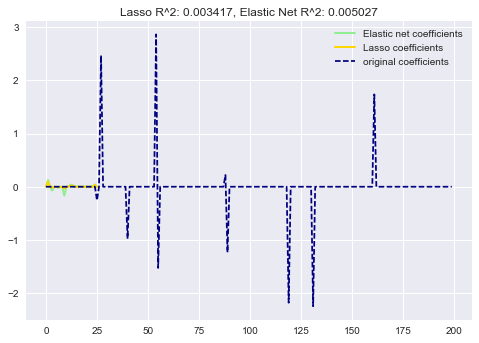

In [24]:
from sklearn.linear_model import ElasticNet
params ={"alpha":[1,0.1,0.01,0.001],
        'l1_ratio':[0.1,0.2,0.4]}
clf_enet, Xtrain_enet, ytrain_enet, Xtest_enet, ytest_enet  = do_classify(ElasticNet(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)
y_pred_enet = clf_enet.fit(Xtrain_enet, ytrain_enet).predict(Xtest_enet)
r2_score_enet = r2_score(ytest_enet, y_pred_enet)

print("r^2 on test data : %f" % r2_score_enet)

plt.plot(clf_enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(clf_lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0 
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']
params ={'criterion': ["gini","entropy"],
 'max_depth': [1,3, 10],
 'max_features': [1, 3, 10],
 'min_samples_leaf': [ 3,10],
 'min_samples_split': [3,10]}
clf_dtree, Xtrain_dtree, ytrain_dtree, Xtest_dtree, ytest_dtree  = do_classify(DecisionTreeClassifier(), 
                                                           params, 
                                                           top_ten_no_na, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 3}
Accuracy on training data: 0.81247
Accuracy on test data:     0.81561


In [26]:
test_prediction_dtree=clf_dtree.predict(Xtest_dtree)
print(confusion_matrix(ytest_dtree,test_prediction_dtree))
print(classification_report(ytest_dtree,test_prediction_dtree))

[[3773    0]
 [ 853    0]]
             precision    recall  f1-score   support

          0       0.82      1.00      0.90      3773
          1       0.00      0.00      0.00       853

avg / total       0.67      0.82      0.73      4626



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** Same problem for Decision trees as well? **

# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
params={'n_estimators':[500,1000]}
clf_rf, Xtrain_rf, ytrain_rf, Xtest_rf, ytest_rf  = do_classify(RandomForestClassifier(), 
                                                           params, 
                                                           top_ten_no_na, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'n_estimators': 500}
Accuracy on training data: 0.99865
Accuracy on test data:     0.82555


In [28]:
test_prediction_rf=clf_rf.predict(Xtest_rf)
print(confusion_matrix(ytest_rf,test_prediction_rf))
print(classification_report(ytest_rf,test_prediction_rf))

[[3768    5]
 [ 802   51]]
             precision    recall  f1-score   support

          0       0.82      1.00      0.90      3773
          1       0.91      0.06      0.11       853

avg / total       0.84      0.83      0.76      4626



### We're getting a lot of false positives meaning predicting the song will be a top ten hit when it isn't.

# Support Vector Classification

In [29]:
from sklearn.svm import SVC
params ={'C':[1],
 'cache_size':[200],
 'degree':[3],
 'gamma':['auto'], 
 'kernel':['rbf'],
 'max_iter':[-1],
 'tol':[0.001]}
clf_svc, Xtrain_svc, ytrain_svc, Xtest_svc, ytest_svc  = do_classify(SVC(), 
                                                           params, 
                                                           top_ten_no_na, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'C': 1, 'cache_size': 200, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'tol': 0.001}
Accuracy on training data: 0.99708
Accuracy on test data:     0.82555


In [30]:
test_prediction_svc=clf_svc.predict(Xtest_svc)
print(confusion_matrix(ytest_svc,test_prediction_svc))
print(classification_report(ytest_svc,test_prediction_svc))

[[3769    4]
 [ 803   50]]
             precision    recall  f1-score   support

          0       0.82      1.00      0.90      3773
          1       0.93      0.06      0.11       853

avg / total       0.84      0.83      0.76      4626



# KNN 

In [31]:
from sklearn.neighbors import KNeighborsClassifier
params ={}
clf_knn, Xtrain_knn, ytrain_knn, Xtest_knn, ytest_knn  = do_classify(KNeighborsClassifier(), 
                                                           params, 
                                                           top_ten_no_na, feature_cols, 'top_ten_hit',1)
test_prediction_knn=clf_knn.predict(Xtest_knn)
print(confusion_matrix(ytest_knn,test_prediction_knn))
print(classification_report(ytest_knn,test_prediction_knn))

BEST PARAMS {}
Accuracy on training data: 0.82906
Accuracy on test data:     0.78599
[[3569  204]
 [ 786   67]]
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      3773
          1       0.25      0.08      0.12       853

avg / total       0.71      0.79      0.74      4626



# Neural Network

In [33]:
from sklearn.preprocessing import StandardScaler
X=top_ten_no_na[feature_cols].values
y=top_ten_no_na['top_ten_hit'].values
Xtrain_nn, Xtest_nn, ytrain_nn, ytest_nn  = train_test_split(X, y, train_size=0.8,random_state=6)                                                          
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(Xtrain_nn)
X_train_nn = scaler.transform(Xtrain_nn)
X_test_nn = scaler.transform(Xtest_nn)

Next we create an instance of the model, there are a lot of parameters you can choose to define and customize here, we will only define the hidden_layer_sizes. For this parameter you pass in a tuple consisting of the number of neurons you want at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. There are many ways to choose these numbers, but for simplicity we will choose 3 layers with the same number of neurons as there are features in our data set

In [34]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(16,16,16))
mlp.fit(X_train_nn,ytrain_nn)
predictions = mlp.predict(X_test_nn)
print(confusion_matrix(ytest_nn,predictions))
print(classification_report(ytest_nn,predictions))

[[3746   39]
 [ 827   14]]
             precision    recall  f1-score   support

          0       0.82      0.99      0.90      3785
          1       0.26      0.02      0.03       841

avg / total       0.72      0.81      0.74      4626



# GBM Tree

In [76]:
#Import libraries:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

X = top_ten_no_na_dum[linear_feature_cols]
y = top_ten_no_na_dum['top_ten_hit']

Keeping all this in mind, we can take the following approach:

    Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
    Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
    Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
    Lower the learning rate and increase the estimators proportionally to get more robust models.

 
Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

    min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
    min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
    max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
    max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
    subsample = 0.8 : This is a commonly used used start value

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees for that. For this purpose, we can do a grid search and test out values from 20 to 80 in steps of 10.

In [78]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['top_ten_hit'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['top_ten_hit'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['top_ten_hit'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['top_ten_hit'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [84]:
#Choose all predictors except target & IDcols
predictors = linear_feature_cols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, top_ten_no_na_dum, predictors)


Model Report
Accuracy : 0.8145
AUC Score (Train): 0.668991
CV Score : Mean - 0.531543 | Std - 0.03301348 | Min - 0.4836115 | Max - 0.5775754


In [86]:
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators':[20,81,10]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 81, 10]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='roc_auc', verbose=0)

In [87]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.53128, std: 0.03093, params: {'n_estimators': 20},
  mean: 0.53217, std: 0.02733, params: {'n_estimators': 81},
  mean: 0.52948, std: 0.02890, params: {'n_estimators': 10}],
 {'n_estimators': 81},
 0.5321711693632977)

# Linear Modelling
http://scikit-learn.org/stable/modules/linear_model.html

# MARS: Multiadaptive Regressive Splines

logistic, cubist, lasso/ridge regression, elastic net regression, SVM, decision tree, GVM tree, random forest tree, neural networks.

correlation matrix, outlier detection, VIF variance inflation factor

In [ ]:


# Split-out validation dataset
array = top_ten_prediction.values
X = array[:,0:15]
Y = array[:,15]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)